In [ ]:
try:
    import pyro
except:
    ! pip install pyro-ppl
    ! pip install Biopython

     |████████████████████████████████| 718 kB 30.1 MB/s 
     |████████████████████████████████| 2.3 MB 33.8 MB/s 


## IID Model

In [ ]:
import pyro
import torch
from helper import *
from PyroModel import *
from JAXFunctions import *
from Error_measure import *
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyro.infer import SVI, Trace_ELBO
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import os
import re

from ASR import ASR

from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPRegressor

import pickle

In [ ]:
AA_dict, back_AA_dict = get_AA_dict(n_c=24)
S_train, S_names_train, S_char_train = load_MSA_Data("/content/BLAT_ECOLX_1_b0.5.fasta", "cuda", AA_dict)
# S_train = S_train[:500]
# S_names_train = S_names_train[:500]
# S_char_train = S_char_train[:500]

S_down, S_names_down, S_char_down = load_MSA_Data("//content/mutation.fas", "cuda", AA_dict)

In [ ]:
Classify_train_p = []
Classify_test_p = []

Classify_train_s = []
Classify_test_s = []

Rec_Acc = []
Rec_Acc_remove_gap = []

In [ ]:
with open("/content/Labels.pkl", "rb") as f:
    Labels = pickle.load(f)

In [ ]:
batch_size = 50

In [ ]:
S_onehot_down = torch.zeros_like(S_down[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_down[:, :, None], 1)
MSA_down = S_onehot_down[:, :, :].float().cuda()

label_down = np.array([Labels[i] for i in S_names_down])

np.random.seed(42)
indices = np.random.choice(label_down.shape[0], label_down.shape[0], False)
np.random.seed(None)

indices_train = indices[: int(indices.shape[0] * 0.7)]
indices_test = indices[int(indices.shape[0] * 0.7):]

label_train = label_down[indices_train]
label_test = label_down[indices_test]

In [ ]:
for _ in range(5):
    for _ in range(5):
        Classify_train_p.append([])
        Classify_test_p.append([])

        Classify_train_s.append([])
        Classify_test_s.append([])

    Rec_Acc.append([])
    Rec_Acc_remove_gap.append([])

    pyro.clear_param_store()
    vae = VAE(100, 24, S_train.shape[1])
    def per_param_callable(module_name, param_name):
        # if param_name in ["msa_ref_loc"]:
        #     return {"lr": 1, "clip_norm": 10}
        # else:   
        return {"lr": 0.0005, "clip_norm": 10}
    optimizer = pyro.optim.ClippedAdam(per_param_callable)
    svi = SVI(vae.iid_model, vae.iid_guide, optimizer, loss=Trace_ELBO(num_particles=1))




    for b in tqdm(range(21)):
        for batch in range(int(np.ceil(S_train.shape[0] / batch_size))):
            s = S_train[batch_size * batch: batch_size * (batch + 1)]
            elbo = svi.step(s, S_train.shape[0] / s.shape[0])

        if b % 5 == 0:
            with torch.no_grad():
                # Rec ACC
                S_onehot = torch.zeros_like(S_train[:, :, None]).expand([-1, -1, 24]).clone().scatter_(-1, S_train[:, :, None], 1)
                MSA = S_onehot[:, :, :].float().cuda()

                Z_loc = vae.encoder(MSA, None).detach()
                re_MSA = vae.decoder.forward(None, Z_loc, False)

                Rec_Acc_remove_gap[-1].append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=True)))
                Rec_Acc[-1].append(np.mean(reconstruction_accuracy(re_MSA, MSA, gap_index=23, remove_gap=False)))

        with torch.no_grad():
            # downstream tast
            x_down = vae.encoder(MSA_down, None).detach().cpu()#torch.cat([vae.encoder(MSA_down, None).detach().cpu(), vae.encoder(MSA_down_wt, None).detach().cpu()], dim=-1)

            x_train = x_down[indices_train]
            x_test = x_down[indices_test]

            for _i in range(5):


                #classifier = MLPRegressor((100, 300, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
                classifier = MLPRegressor((100, 300, 100), alpha=0.3, max_iter=500).fit(x_train, label_train)
                acc_train = pearsonr(label_train, classifier.predict(x_train))[0]
                Classify_train_p[-1-_i].append(acc_train)

                acc_train = spearmanr(label_train, classifier.predict(x_train))[0]
                Classify_train_s[-1-_i].append(acc_train)

                acc_test = pearsonr(label_test, classifier.predict(x_test))[0]
                Classify_test_p[-1-_i].append(acc_test)

                acc_test = spearmanr(label_test, classifier.predict(x_test))[0]
                Classify_test_s[-1-_i].append(acc_test)




           

100%|██████████| 21/21 [30:06<00:00, 86.04s/it]


In [ ]:
# Classify_train_p = np.array(Classify_train_p).reshape([25, -1])
# Classify_train_s = np.array(Classify_train_s).reshape([25, -1])
# Classify_test_p = np.array(Classify_test_p).reshape([25, -1])
# Classify_test_s = np.array(Classify_test_s).reshape([25, -1])

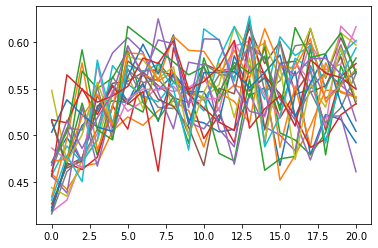

In [ ]:
for i in Classify_test_p:
  plt.plot(i)

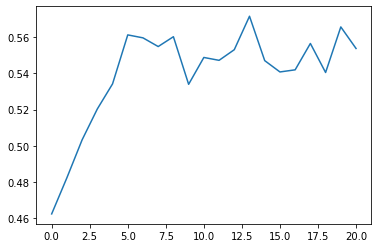

In [ ]:
plt.plot(np.array(Classify_test_p).mean(0))

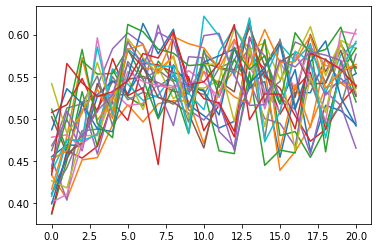

In [ ]:
for i in Classify_test_s:
  plt.plot(i)

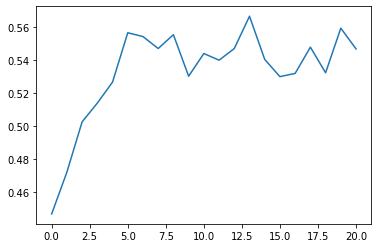

In [ ]:
plt.plot(np.array(Classify_test_s).mean(0))

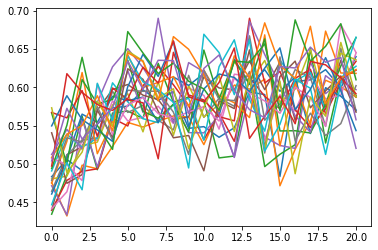

In [ ]:
for i in Classify_train_p:
  plt.plot(i)

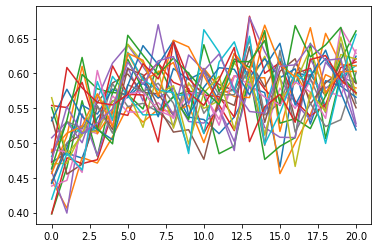

In [ ]:
for i in Classify_train_s:
  plt.plot(i)

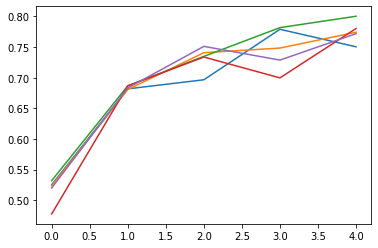

In [ ]:
for i in Rec_Acc:
  plt.plot(i)

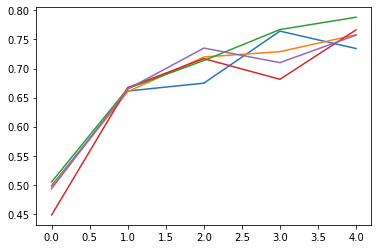

In [ ]:
for i in Rec_Acc_remove_gap:
  plt.plot(i)

In [ ]:
import pickle

with open("track_iid_522.pkl", "wb") as f:
    pickle.dump((Classify_train_p, Classify_test_p, Classify_train_s, Classify_test_s, Rec_Acc, Rec_Acc_remove_gap), f)

In [ ]:
from google.colab import files
files.download("track_iid_522.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>